In [3]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.visualization.vis_data import *

#set bokeh output
output_notebook()
# change plt font size
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Compare AQI

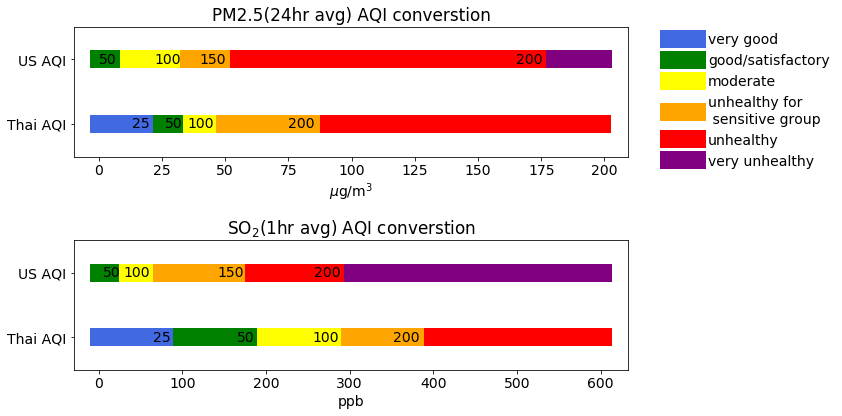

In [4]:
compare_aqis(filename='../reports/chiang_mai/aqi.png')

# A Dataset Object

It is more convenience to have a `Dataset` object that keep tracks of all relavant data for a city along with necessary meta information such as city location etc. This is object is under `src.features.dataset.py`.

The `Dataset` object is also in charge of compile raw pollution, weather, fire data from the data folder into a ready-to-use format using `dataset.build_all_data()`. The processed data are saved under ../data/city_name/. The code below illustrates how to `Dataset` object compile the data using a build_all_data command. This object also keep track of feature engineering parameters during the model optimization step[notebook](https://github.com/worasom/aqi_thailand2/blob/master/notebooks/5.0-ML_ChiangMai.ipynb). For the Dataset object's documentation, please refer to https://github.com/worasom/aqi_thailand2/blob/master/docs/_build/html/src.features.html.

In [ ]:
# init a dataset object and build the data from scratch 
# only perform this when new data files are added 
dataset = Dataset('Chiang Mai')

# build pollution,  weather data and (optional) fire data
dataset.build_all_data( build_fire=True, build_holiday=True)

After the building process, which might take sometimes because of the size of the fire data (building the fire data is optional and can be set to false (`build_fire=False`). The complied data can be loaded using `_load()` command.

In [5]:
# reinit the data and load saved process data 
dataset = Dataset('Chiang Mai')
dataset.load_()

The hourly pollution data, weather data, and fire data are under `dataset.poll_df`, `dataset.wea` and `dataset.fire` attributes accordingly. Each data is a panda dataframe with datetime index. For example, the pollution data for Chiang Mai looks like

In [48]:
print(dataset.poll_df.tail(2).to_markdown())

| datetime            |   PM2.5 |   PM10 |   O3 |   CO |   NO2 |   SO2 |
|:--------------------|--------:|-------:|-----:|-----:|------:|------:|
| 2020-06-17 15:00:00 |     8.5 |   19.5 |   15 | 0.4  |     5 |     1 |
| 2020-06-17 16:00:00 |     7.5 |   16.5 |   11 | 0.43 |     5 |     1 |


Additionally the dataset also has city information under `city_info` attribute

In [27]:
dataset.city_info

{'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok',
 'lat_km': 2117.0,
 'long_km': 11019.0}

# Geography

I have two handy functions to convert logtitude, latitude coordinates to Mercator projection and vice versa. They are `src.gen_functions.merc_x`, `src.gen_functions.merc_y`, and `src.gen_functions.to_latlon`

In [6]:
# Location of power plants
plant1 = [18.291836, 99.747635, 'coal']
plant2 = [19.199594, 97.981650, 'diesel']
plant3 = [18.188042, 97.934958, 'diesel']
plant4 = [16.629450, 99.870301, 'natural gas']

plant_list = [plant1[:2], plant2[:2], plant3[:2], plant4[:2]]
plant_list = [plant1, plant2, plant3, plant4]

plant_list = np.vstack(plant_list)
plant_x = merc_x(plant_list[:,1].astype(float))
plant_y = [merc_y(y) for y in  plant_list[:,0]]

In [7]:
# location of industrial complex 
industrial_loc = [18.595537, 99.044438]
ind_x = merc_x(industrial_loc[1])
ind_y = merc_y(industrial_loc[0])

In [8]:
# load city center from the dataset object and convert to mercator
city_x = merc_x(dataset.city_info['Longitude'])
city_y = merc_y(dataset.city_info['Latitude'])

In [12]:
# load Thailand PCD station locations for Chiang Mai
# this information is stored in the raw data folder

# load station information file 
aqm_folder = '../data/aqm_hourly2/'
# load stations information for air4 Thai
station_info_file = aqm_folder + 'stations_locations.json'
with open(station_info_file, 'r',encoding="utf8") as f:
    station_info = json.load(f)
station_info = station_info['stations']

In [13]:
station_info

[{'stationID': 'o20',
  'nameTH': ' ศาลากลางจังหวัดกระบี',
  'nameEN': 'Krabi Town Hall',
  'areaTH': 'ต.ปากน้ำ อ.เมือง, กระบี่',
  'areaEN': 'Mueang District, Krabi',
  'stationType': 'MOBILE',
  'lat': '8.059199',
  'long': '98.918138',
  'LastUpdate': {'date': '2020-09-12',
   'time': '10:00',
   'PM25': {'value': '4', 'unit': 'µg/m³'},
   'PM10': {'value': 'N/A', 'unit': 'µg/m³'},
   'O3': {'value': 'N/A', 'unit': 'ppb'},
   'CO': {'value': 'N/A', 'unit': 'ppm'},
   'NO2': {'value': 'N/A', 'unit': 'ppb'},
   'SO2': {'value': 'N/A', 'unit': 'ppb'},
   'AQI': {'Level': '1', 'aqi': '4'}}},
 {'stationID': '02t',
  'nameTH': 'มหาวิทยาลัยราชภัฏบ้านสมเด็จเจ้าพระยา',
  'nameEN': 'Bansomdejchaopraya Rajabhat University',
  'areaTH': 'แขวงหิรัญรูจี เขตธนบุรี, กรุงเทพฯ',
  'areaEN': 'Hiran Ruchi, Khet Thon Buri, Bangkok',
  'stationType': 'GROUND',
  'lat': '13.732994',
  'long': '100.488239',
  'LastUpdate': {'date': '2020-09-12',
   'time': '11:00',
   'PM25': {'value': '10', 'unit': 'µg/m³

In [15]:
# load Thailand PCD station locations for Chiang Mai
# this information is stored in the raw data folder

# load station information file 
aqm_folder = '../data/aqm_hourly2/'
# load stations information for air4 Thai
station_info_file = aqm_folder + 'stations_locations.json'
with open(station_info_file, 'r',encoding="utf8") as f:
    station_info = json.load(f)
station_info = station_info['stations']

# Chiang mai station ids
cm_station_ids = ['35t', '36t']

cm_station_coor = []
for station in station_info:
    if station['stationID'] in cm_station_ids:
        lat = merc_y(station['lat'])
        long = merc_x(station['long'])
        cm_station_coor.append([lat, long])
cm_station_coor = np.array(cm_station_coor)

In [17]:
# set the size of the map 
stepx = 2E5
stepy = stepx

# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-stepx,city_x+1.2*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Power Plants and Industrical Site')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))
p.scatter(plant_x,plant_y,color='red',line_color='black',size=10, legend_label='power plants')

p.circle(ind_x, ind_y,color='blue',line_color='black',size=10, legend_label='industrial complex')

p.scatter(cm_station_coor[:,1],cm_station_coor[:,0],color='magenta', line_color='black',size=10, legend_label='PCD stations')


show(p)
export_png(p, filename='C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/chiang_mai/cm_map.png')

'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\chiang_mai\\cm_map.png'

# Data Exploration

In [18]:
# Extract the pollution data 
poll_df = dataset.poll_df
city_name = dataset.city_name

Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


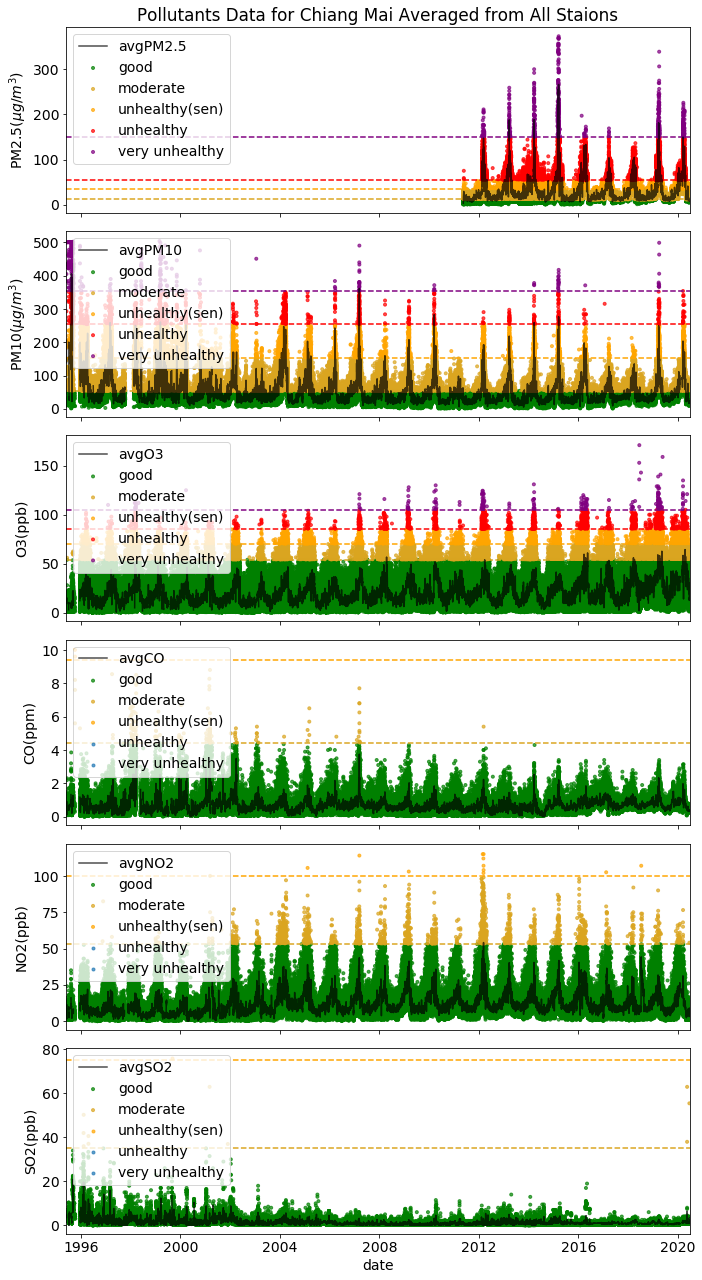

In [19]:
# looking at the raw data
plot_all_pollutions(poll_df, city_name=city_name)

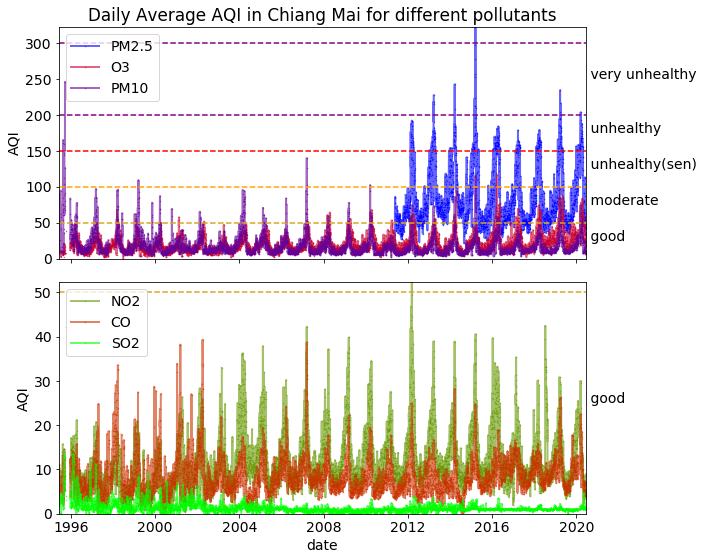

In [11]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

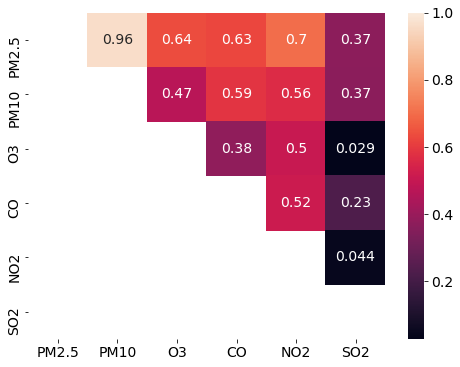

In [21]:
# understanding Pearson correlation between data. I use spearman
plot_corr(dataset.poll_df.resample('d').mean(), filename=dataset.report_folder+'poll_corr.png')

aqi 100 in  12-13 to 05-11
aqi 150 in  02-21 to 04-21


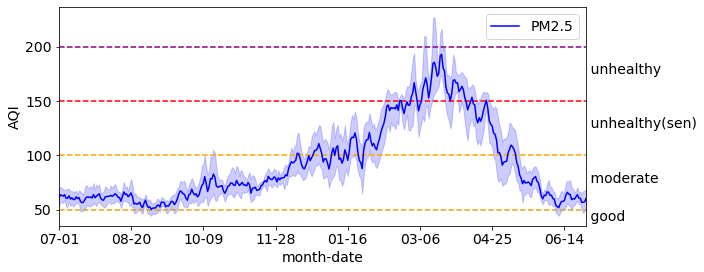

In [14]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25_aqi.png')

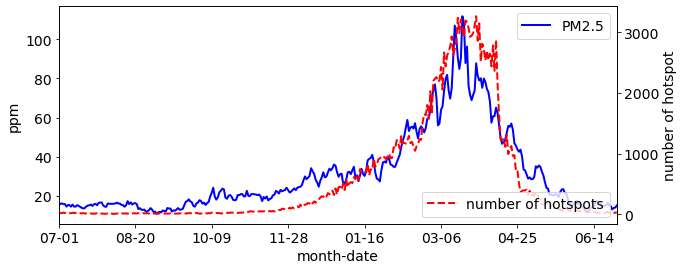

In [79]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
#poll_aqi = poll_to_aqi(data.poll_df.copy(), data.roll_dict)
winter_day_dict, mean_day = plot_season_avg(dataset.poll_df.copy(), 'PM2.5', ax, plot_error=False, roll=True, agg='mean',linewidth=2 )

ax.set_ylabel('ppm')
ax1 = ax.twinx()
fire_hour = dataset.fire[['count']].resample('d').sum()
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.copy(), 'number of hotspots', ax1, plot_error=False, roll=False, agg='mean',color='red',linestyle='dashed',linewidth=2)

ax1.legend(loc='lower right')
ax1.set_ylabel('number of hotspot')
plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

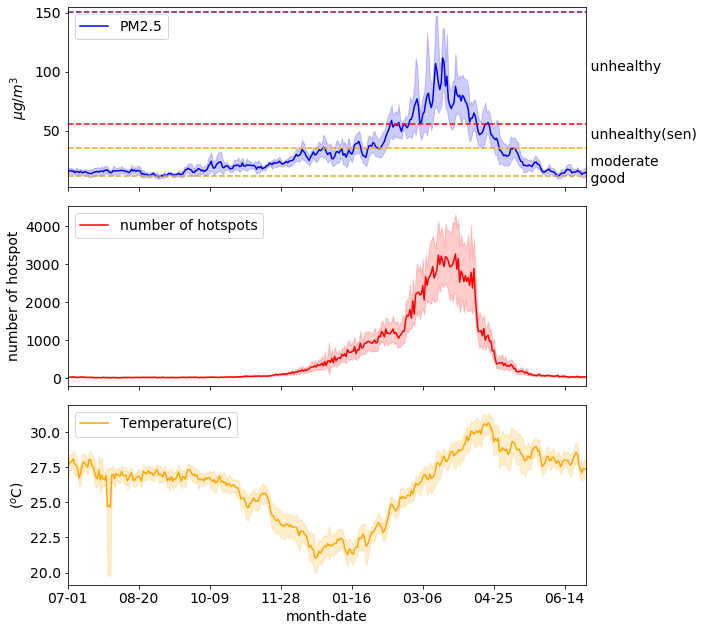

In [16]:
compare_seson_avg(dataset, wea_col=['Temperature(C)'], agg='mean', filename=dataset.report_folder + 'fire_PM25_t_season.png')

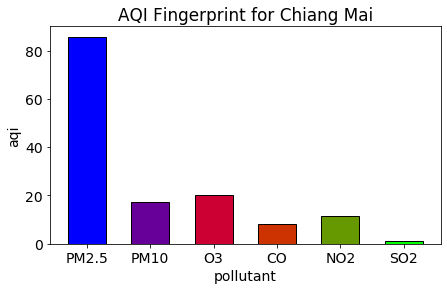

In [3]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

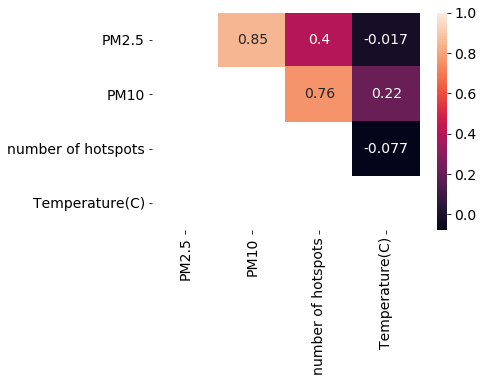

In [156]:
plot_corr(year_avg, figsize=(6,4))

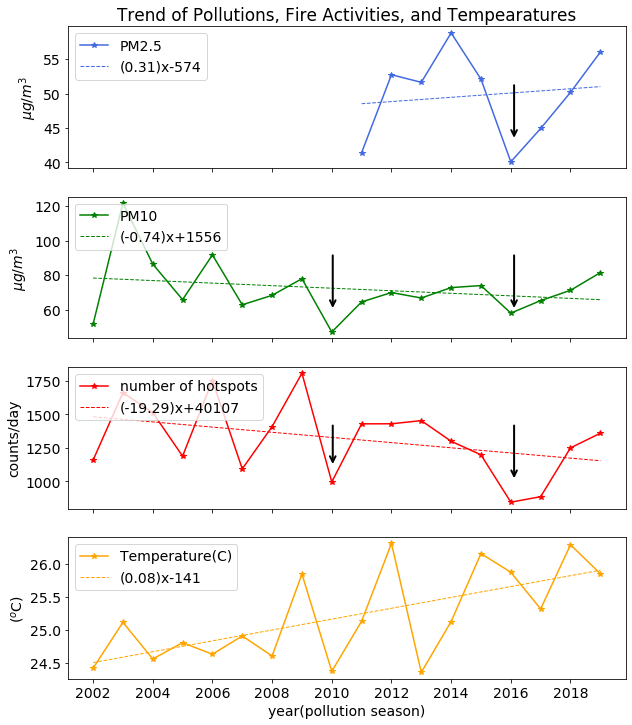

In [77]:
ax, year_avg = plot_yearly_ln(dataset)

for i, a in enumerate(ax):
    if i != 3:
        a.annotate('', xy=(0.8, 0.2),xytext=(0.8, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

ax[1].annotate('', xy=(0.475, 0.2),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))
ax[2].annotate('', xy=(0.475, 0.3),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

plt.savefig(data.report_folder + 'compare_ln_trends.png')

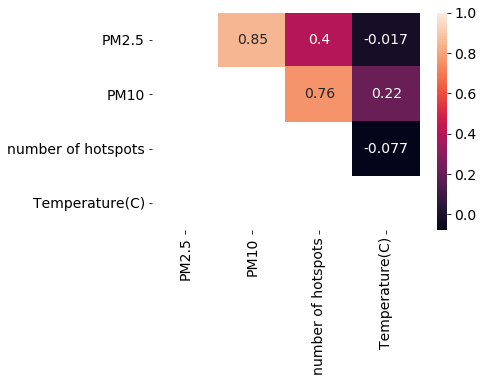

In [78]:
plot_corr(year_avg, figsize=(6,4))

# Analyze Fire activities

I try to show that the hotspots seen from satellite are from agricultural burning not wild fires. One way to do that is to overlay land use data on top of the hotspot data. I will try to do that in the future. Here, I will use an assumption that the wild fire would have a random location and not likely going to occur at the same location in different year. Hotspots from agricultural activities often occur at the same locations. I have to be careful about the spatial resolution of the MODIS instruments, which is 1km. So the location has to be round to 1km. 

I am going first label the hotspot by country of origin, then count the percents of the hotspots with repetition for each country.

## Number of Hotspots by Country

In [38]:
# loading world map
gdf =  gpd.read_file('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/world_maps/map3/')
country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]
gdf.columns = ['OBJECTID', 'NAME', 'geometry']
gdf = gdf[gdf['NAME'].isin(country_list)].reset_index(drop=True)
gdf['NAME'] = ['Myanmar', 'Cambodia', 'China', 'Laos', 'Thailand', 'Vietnam']
gdf = gdf.sort_values('NAME')

# create a 1000 km polygon in mercator in meter
circle_gons = get_circle(x_cen=x, y_cen=y, r=1000*1000, num_data=1E4)
# convert into a tuple 
circle_gons = {'geometry': Polygon(list(map(tuple, circle_gons.transpose())))}

circle_gons = gpd.GeoDataFrame(circle_gons, crs="EPSG:3395",index=[0])
# convert to 6933
circle_6933 = circle_gons['geometry'].to_crs(epsg=6933)
circle_6933 = circle_6933.values[0] 

# calculate the area within 1000 km radius 
temp = gdf.copy()
# convert to mercator
temp['geometry'] = gdf['geometry'].to_crs(epsg=6933)
inter_area = []
for (i, row) in temp.iterrows():
    polygon1 = row['geometry'].intersection(circle_6933) 
    inter_area.append(int(polygon1.area/10**6))
    p = gpd.GeoSeries(polygon1)

gdf['inter_area(km2)'] = inter_area


# load fire data 
dataset = Dataset('Chiang Mai')
# load raw data 
dataset.load_()
fire = dataset.fire.copy()

In [41]:
# obtain the seasonal pattern of fire by country 
fire_country = pd.pivot_table(fire, values='count', columns='country',index=fire.index,aggfunc='sum').fillna(0).astype(int)
fire_country = fire_country.resample('d').sum()
fire_country_sea, winter_day_dict = season_avg(fire_country, cols=fire_country.columns.to_list(), roll=False, agg='sum', offset=182)
fire_country_sea = fire_country_sea.groupby('winter_day').mean()[fire_country.columns]

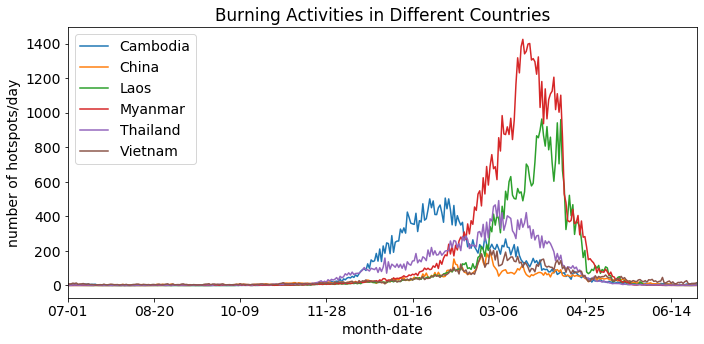

In [52]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(dataset.report_folder + 'hotspots_country.png')

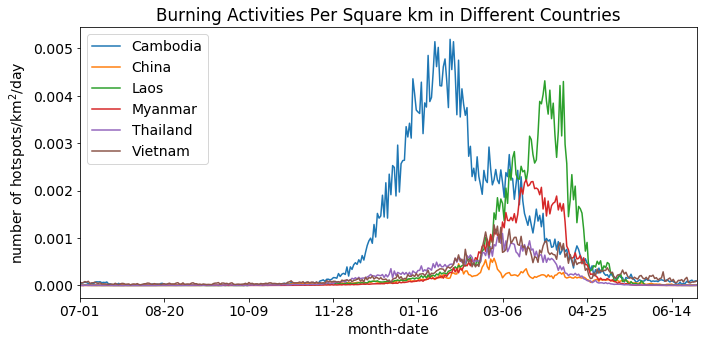

In [51]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea/gdf['inter_area(km2)'].values)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities Per Square km in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/km$^2$/day')
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_per_km2.png')

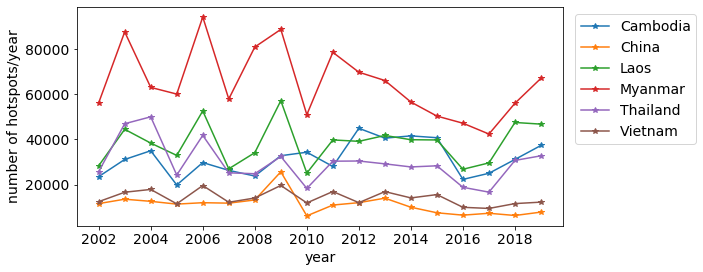

In [57]:
fire_country_year = add_season(fire_country).drop('season',axis=1)

_, ax = plt.subplots(1,1, figsize=(10,4))
fire_country_year.groupby('year').sum().drop(2020).plot(marker='*',ax=ax)
ax.set_ylabel('number of hotspots/year')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_country_year.png')

## Amount of repeating hotspots

In [46]:
# observing a repeating patterns 
fire = dataset.fire.copy()

fire = fire.reset_index()
# add coordinate tuple
factor = 1
fire['coor'] = [(x, y) for x, y in zip(((fire['long_km']/factor).round() *
                                        factor).astype(int), ((fire['lat_km']/factor).round()*factor).astype(int))]
# drop hotspot outside the countrires considered
fire = fire.dropna()
# round the datetime information to day
fire['datetime'] = fire['datetime'].dt.round('d')
country_list = fire['country'].unique()

In [60]:
# repeating hotspots with between year
repeat_out_year_accum = []
repeat_list = [2]
for country in country_list:
    s = cal_repeat_spots(fire[fire['country']==country].set_index('datetime').copy(),repeat_list=repeat_list,accum=True,group_list=['lat_km','long_km'])
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

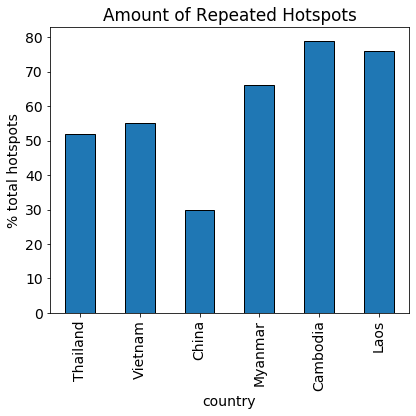

In [61]:
_, ax = plt.subplots(1,1,figsize=(6,6))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = 'Amount of Repeated Hotspots'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_repeat.png')